# Práctica

Se utilizará el <i>framework</i> de __Pytorch__. 

## 1. Entorno Crude Scheduler

### 1.1. Establecer el entorno

En primer lugar cargaremos la librería __gym__ e inicializaremos el entorno.

In [1]:
import gymnasium as gym
from gymnasium.spaces import flatten as flat
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from collections import namedtuple, deque
import os
import IPython.display
import sklearn
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

from tankEnv import *

env = gym.envs.make('crudeTanksEnv-v0')

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 10)
  logger.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation sha

In [2]:
print('Is torch cuda available?: {}'.format(torch.cuda.is_available()))

Is torch cuda available?: False


In [3]:
env.spec

EnvSpec(id='crudeTanksEnv-v0', entry_point=<class 'tankEnv.crudeTanksEnv'>, reward_threshold=850, nondeterministic=False, max_episode_steps=720, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='crudeTanksEnv', version=0)

### Descripción del entorno

### Description  

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with continuous actions.

This MDP first appeared in Andrew Moore’s PhD Thesis (1990)

#### Observation Space  
The observation is a ndarray with shape (2,) where the elements correspond to the following:

Num Observation                              Min  Max   Unit

 0  position of the car along the x-axis    -Inf  Inf   position (m)

 1  velocity of the car                     -Inf  Inf   velocity (m/s)

#### Action Space  
The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

Transition Dynamics:
Given an action, the mountain car follows the following transition dynamics:

velocity<sub>t+1</sub> = velocity<sub>t+1</sub> + force * self.power - 0.0025 * cos(3 * position<sub>t</sub>)

position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>

where force is the action clipped to the range [-1,1] and power is a constant 0.0015. The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].

#### Reward  
A negative reward of -0.1 * action<sup>2</sup> is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

#### Starting State  
The position of the car is assigned a uniform random value in [-0.6 , -0.4]. The starting velocity of the car is always assigned to 0.

#### Episode End  
The episode ends if either of the following happens:

Termination: The position of the car is greater than or equal to 0.45 (the goal position on top of the right hill)

Truncation: The length of the episode is 999.

In [4]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([flat(env.observation_space, env.observation_space.sample()) for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=128)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=128)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=128)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=128))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=128)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=128)),
                               ('rbf3', RBFSampler(n_components=128)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=128))])

In [5]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [6]:
env.action_space.sample()

OrderedDict([('farmTanks', array([1, 4])), ('unitFeed', array(0.79683184))])

## Actor-Critic method


Basado en el ejemplo de pytorch:  

https://medium.com/geekculture/actor-critic-implementing-actor-critic-methods-82efb998c273

In [7]:
class AC_actor(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Actor ANN
        """
        super(AC_actor, self).__init__()

        self.n_inputs = n_inputs
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        # AC Actor
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU()       
        )
        self.actorC = torch.nn.Sequential(
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, 1, bias=True),
            torch.nn.Softplus()
        )
        self.actorD1 = torch.nn.Sequential(
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, 13, bias=True),
            torch.nn.Softmax(dim=-1)
        )
        self.actorD2 = torch.nn.Sequential(
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, 6, bias=True),
            torch.nn.Softmax(dim=-1)
        )

        if self.device == 'cuda':
            self.actor.cuda()
            self.actorC.cuda()
            self.actorD1.cuda()
            self.actorD2.cuda()
        
        self.register_parameter(name='lognu', param=torch.nn.Parameter(torch.tensor(0.1).to(device=self.device)))

        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
        #                                                            patience=200, factor=0.5, min_lr=0.0001, verbose=True)

        # self.init_weights()

    #Obtención de las probabilidades de las posibles acciones
    def get_action(self, state):
        state_t = torch.FloatTensor(featurize_state(state)).to(device=self.device)
        tmp = self.actor(state_t)
        
        mu = self.actorC(tmp)
        if torch.isnan(mu):
            mu = torch.tensor(1.0, device=self.device)
            print('nan mu')
        nu = torch.clamp(self.lognu.exp(), 1e-3, 2)
        
        return torch.distributions.Normal(mu, nu),\
               torch.distributions.Categorical(self.actorD1(tmp)),\
               torch.distributions.Categorical(self.actorD2(tmp))

    def init_weights(self):
        self.actor.apply(self.init_weights_)

    def init_weights_(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(pow(5., -0.5))

In [8]:
class AC_critic(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Critic ANN
        """
        super(AC_critic, self).__init__()

        self.n_inputs = n_inputs
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        # AC Critic
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1, bias=True)
        )

        if self.device == 'cuda':
            self.critic.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
        #                                                            patience=200, factor=0.5, min_lr=0.00001)
    
    def get_val(self, state):
        state_t = torch.FloatTensor(featurize_state(state)).to(device=self.device)
        return self.critic(state_t)


### Definición del agente


In [9]:
class ACAgent:

    def __init__(self, env, dnnet_actor, dnnet_critic, nblock=100):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.dnnet_actor = dnnet_actor
        self.dnnet_critic = dnnet_critic
        self.device = dnnet_actor.device
        self.nblock = nblock
        self.reward_threshold = env.spec.reward_threshold
        self.initialize()

    def initialize(self):
        self.losses = []
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
    ######

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000):
        self.gamma = gamma

        episode = 0
        self.mean_rewards = -1000.0
        self.maxRewards = 0.0
        training = True
        epsilon_max = 0.05
        epsilon_min = 0.001
        epsilon = epsilon_max
        print("Training...")
        while training:
            state0, data = env.reset()
            actionAvail = data['actionAvail']
            state0 = flat(env.observation_space, state0)
            episode_rewards = []
            gamedone = False
            t = 0
            I = 1
            while gamedone == False:
                cProb, d1Prob, d2Prob = self.dnnet_actor.get_action(state0)
                cAction = cProb.sample()
                cAction = torch.clamp(cAction, 0.1, 1.0)
                #d1Prob = torch.distributions.Categorical(d1Prob.probs * torch.tensor(actionAvail[0], device=self.dnnet_actor.device))
                #d2Prob = torch.distributions.Categorical(d2Prob.probs * torch.tensor(actionAvail[1], device=self.dnnet_actor.device))
                if actionAvail[0].any():
                    d1Prob.probs = d1Prob.probs * torch.tensor(actionAvail[0]+1E-5, device=self.dnnet_actor.device)
                if actionAvail[1].any():
                    d2Prob.probs = d2Prob.probs * torch.tensor(actionAvail[1]+1E-5, device=self.dnnet_actor.device)
                d1Action = d1Prob.sample()
                d2Action = d2Prob.sample()
                if np.random.random() < epsilon:
                    action = env.action_space.sample() # acción aleatoria
                    while not (actionAvail[0][action['farmTanks'][0]] and actionAvail[1][action['farmTanks'][1]]): 
                        action = env.action_space.sample() # acción aleatoria
                    d1Action = torch.tensor(action['farmTanks'][0], device=self.dnnet_actor.device, dtype=torch.int)
                    d2Action = torch.tensor(action['farmTanks'][1], device=self.dnnet_actor.device, dtype=torch.int)
                    action['unitFeed'] = np.array([cAction.item()])
                    #cAction = torch.tensor(action['unitFeed'], device=self.dnnet_actor.device, dtype=torch.int)
                else:
                    action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                                          'unitFeed': np.array([cAction.item()])})
                
                val = self.dnnet_critic.get_val(state0)
                
                prob_log = cProb.log_prob(cAction) + d1Prob.log_prob(d1Action) + d2Prob.log_prob(d2Action)

                new_state, reward, gamedone, _, info = env.step(action)
                actionAvail = info['actionAvail']
                new_state = flat(env.observation_space, new_state)
                
                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_rewards.append(reward)
                
                reward_t = torch.tensor([reward], device=self.device, dtype=torch.float)
                new_val = self.dnnet_critic.get_val(new_state)
                #if terminal state, next state val is 0
                if gamedone:
                    new_val = torch.tensor([0], device=self.device, dtype=torch.float)
                    #if t < 700:
                    #    print(action, actionAvail)
                
                #calculate value function loss with MSE
                advantage = reward_t + self.gamma * new_val - val
                loss_critic = advantage.square()
                loss_critic *= I
                
                #calculate policy loss
                loss_actor = -prob_log * advantage.detach()
                loss_actor *= I
                
#                 if t % 100 == 0:
#                     print(cProb.log_prob(cAction), d1Prob.log_prob(d1Action), d2Prob.log_prob(d2Action))
                
                #Backpropagate policy
                self.dnnet_actor.optimizer.zero_grad()
                loss_actor.backward()
                torch.nn.utils.clip_grad_value_(self.dnnet_actor.parameters(), 10.0) 

                #Backpropagate value
                self.dnnet_critic.optimizer.zero_grad()
                loss_critic.backward()
                torch.nn.utils.clip_grad_value_(self.dnnet_critic.parameters(), 10.0) 

                nActor, nCritic = self.norm2()
                if t > 0:
                    nActorMean = (nActorMean*t+nActor)/(t+1)
                    nCriticMean = (nCriticMean*t+nCritic)/(t+1)                    
                else:
                    nActorMean = nActor
                    nCriticMean = nCritic
                
                self.dnnet_actor.optimizer.step()
                # self.dnnet_actor.lr_sched.step(self.mean_rewards)

                self.dnnet_critic.optimizer.step()
                # self.dnnet_critic.lr_sched.step(self.mean_rewards)

                state0 = deepcopy(new_state)
                I *= self.gamma
                t += 1
                

            episode += 1

            self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas
            self.mean_rewards = np.mean(self.training_rewards[-self.nblock:])
            self.mean_training_rewards.append(self.mean_rewards)

            if self.training_rewards[-1] > self.maxRewards:
                self.maxRewards = self.training_rewards[-1]
                self.maxS = deepcopy(env.S)
            
            # Comprobamos que todavía quedan episodios
            if episode >= max_episodes:
                training = False
                print('\nEpisode limit reached.')
                break

            epsilon = max(epsilon*0.99, epsilon_min)

            if episode > 100 and episode % 100 == 0:
                self.plot_rewards()

            print("\rEpisode {:3d} Mean Rewards {:.2f} Last Reward {:.2f}  n_steps {:3d} Epsilon {:.3f} "
                "nActor {:.3f} nCritic {:.3f}\t\t".format(
                episode, self.mean_rewards, np.mean(self.training_rewards[-1]), t, epsilon, 
                nActorMean, nCriticMean), end="")

            # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
            if self.mean_rewards >= self.reward_threshold and episode > self.nblock:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(
                    episode))
                break

    def plot_rewards(self):
       
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.env.spec.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()

    def norm2(self):
        norm = lambda parameters : torch.norm(torch.stack([torch.norm(p.grad.detach(), 2) for p in parameters]), 2)
        pActor = self.dnnet_actor.parameters()
        pCritic = self.dnnet_critic.parameters()
        return norm(pActor), norm(pCritic)
        

### Entrenamiento


In [10]:
lr_actor = 5.E-5     #Velocidad de aprendizaje   0.005
lr_critic = 5.E-4    #Velocidad de aprendizaje   0.005
GAMMA = 0.99         #Valor gamma de la ecuación de Bellman
NBLOCK = 100         #Número de steps para rellenar el buffer
MAX_EPISODES = 5000  #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)

In [11]:
ACa = AC_actor(env, 512, learning_rate=lr_actor, device='cuda')

In [12]:
ACc = AC_critic(env, 512, learning_rate=lr_critic, device='cuda')

In [13]:
AC_agent = ACAgent(env, ACa, ACc, NBLOCK)

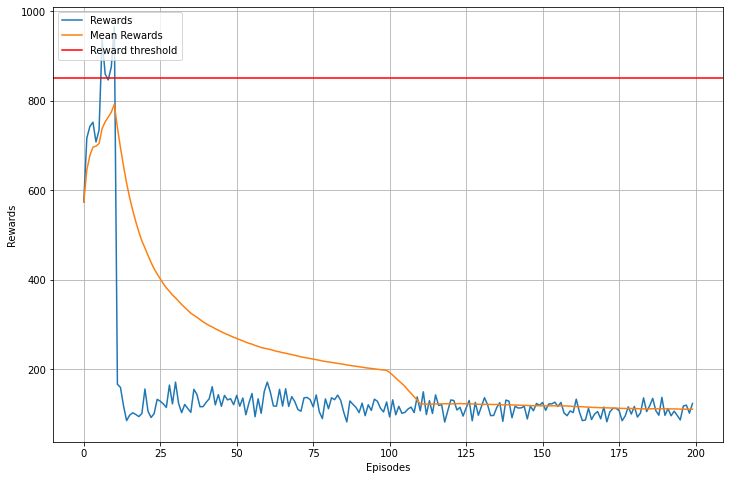

Episode 206 Mean Rewards 110.26 Last Reward 83.54  n_steps 223 Epsilon 0.006 nActor 2.255 nCritic 0.494		

KeyboardInterrupt: 

In [ ]:
%%time

AC_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES)

In [ ]:
np.array([False, True, False]) + 1E-5

In [ ]:
AC_agent.maxS.render()

In [ ]:
AC_agent.maxS.prodsLog[300]

In [ ]:
AC_agent.plot_rewards()

In [ ]:
myfile = 'agentACDT_Trained_Model.pth'
if os.path.isfile(myfile):
    os.remove(myfile)
torch.save(ACa.state_dict(), myfile)

In [ ]:
%%time

env = gym.envs.make("crudeTanksEnv-v0")

AC = AC_actor(env, 512, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

state0 = flat(env.observation_space, env.reset()[0])
done = False
episode_reward = 0
n = 0
action_list = []
while not done:
    cProb, d1Prob, d2Prob = AC.get_action(state0)
    cAction = cProb.sample()
    cAction = torch.clamp(cAction, min=0.0, max=1.0)
    d1Action = d1Prob.sample()
    d2Action = d2Prob.sample()
    action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                          'unitFeed': np.array([cAction.item()])})
    state, reward, done, _, _ = env.step(action)
    state = flat(env.observation_space, state)
    episode_reward += reward
    n += 1
    state0 = deepcopy(state)
    if n >= env.spec.max_episode_steps:
        done = True

print('n: {:4d}   reward: {:4.2f}'.format(n, episode_reward))
env.render()
print('\n')

In [ ]:
list(AC.parameters())

In [ ]:
%%time

env = gym.envs.make("crudeTanksEnv-v0")

AC = AC_actor(env, 512, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

reward_list = []
n_list = []
for n_episodes in range(20):
    state0 = flat(env.observation_space, env.reset()[0])
    done = False
    episode_reward = 0
    n = 0
    action_list = []
    while not done:
        cProb, d1Prob, d2Prob = AC.get_action(state0)
        cAction = cProb.sample()
        d1Action = d1Prob.sample()
        d2Action = d2Prob.sample()
        action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                              'unitFeed': np.array([cAction.item()])})
        state, reward, done, _, _ = env.step(action)
        state = flat(env.observation_space, state)
        episode_reward += reward
        n += 1
        state0 = deepcopy(state)
        if n >= env.spec.max_episode_steps:
            done = True

    print('{:2d} n: {:4d}   reward: {:4.2f}'.format(n_episodes+1, n, episode_reward))
    reward_list.append(episode_reward)
print('\n')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

fig.suptitle('Recompensa de 20 partidas con el modelo ajustado')

ax.plot(reward_list)
ax.axhline(y=env.spec.reward_threshold, color='r', linestyle='-')
ax.set_xlabel('suma de recompensas de cada partida')
ax.set_xticks(range(20))
ax.grid()

plt.show()